# 08 - Final Production Forecast

This notebook demonstrates production-style forecasting using an ensemble model that combines the best-performing approaches from our model comparison analysis.

## Objectives

1. **Build an ensemble model** combining top performers (Seasonal Naive + XGBoost)
2. **Train on the full dataset** to maximize available information
3. **Generate 7-day forecasts** for all key metrics:
   - `daily_logins`
   - `daily_deposits`
   - `daily_deposit_volume_gbp`
4. **Visualize forecasts** with historical context and confidence indicators
5. **Export results** for downstream consumption

---

## 1. Setup and Imports

In [1]:
import sys
import warnings
from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import models
from volume_forecast.models import (
    EnsembleModel,
    SeasonalNaiveModel,
    XGBoostModel,
    MovingAverageModel,
)

# Import data generator (for creating data if needed)
from volume_forecast.data_generation import VolumeGenerator

# Import evaluation metrics
from volume_forecast.evaluation import mae, rmse, mape

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("Volume Forecasting POC - Final Production Forecast")
print("=" * 50)
print(f"Project Root: {project_root}")
print("Setup complete!")

Volume Forecasting POC - Final Production Forecast
Project Root: C:\Users\juanlu\dev\volume-forecasting-poc
Setup complete!


## 2. Load Data

Load the synthetic volume data. If the data file does not exist, we generate it using the `VolumeGenerator`.

In [2]:
# Define data paths
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"
output_path = project_root / "data" / "processed" / "forecast_output.csv"

# Load or generate data
if data_path.exists():
    df = pd.read_csv(data_path, parse_dates=["date"])
    print(f"Loaded data from {data_path}")
else:
    print(f"Data file not found at {data_path}. Generating synthetic data...")
    generator = VolumeGenerator(seed=42)
    df = generator.generate(
        start_date=date(2023, 1, 1),
        end_date=date(2024, 12, 31),
        include_events=True
    )
    # Save for future use
    data_path.parent.mkdir(parents=True, exist_ok=True)
    generator.save(df, data_path)
    print(f"Generated and saved data to {data_path}")

# Ensure chronological order
df = df.sort_values('date').reset_index(drop=True)

# Display data summary
print(f"\nDataset Overview")
print("-" * 40)
print(f"Shape: {df.shape[0]:,} days x {df.shape[1]} columns")
print(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Columns: {list(df.columns)}")

Loaded data from C:\Users\juanlu\dev\volume-forecasting-poc\data\raw\synthetic_volumes.csv

Dataset Overview
----------------------------------------
Shape: 731 days x 4 columns
Date Range: 2023-01-01 to 2024-12-31
Columns: ['date', 'daily_logins', 'daily_deposits', 'daily_deposit_volume_gbp']


In [3]:
# Quick data inspection
print("\nSample Data (Last 7 Days):")
df.tail(7)


Sample Data (Last 7 Days):


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
724,2024-12-25,142010,32399,730079
725,2024-12-26,162555,39292,764539
726,2024-12-27,58912,9619,337773
727,2024-12-28,78586,14995,387474
728,2024-12-29,57549,10735,334402
729,2024-12-30,43277,8347,221098
730,2024-12-31,48239,6730,205021


In [4]:
# Summary statistics
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
count,731,731.00,731.00,731.00
mean,2024-01-01 00:00:00,"53,162.94","8,914.91","264,106.77"
min,2023-01-01 00:00:00,"23,749.00","3,085.00","122,017.00"
25%,2023-07-02 12:00:00,"41,954.50","6,681.00","205,804.50"
50%,2024-01-01 00:00:00,"48,708.00","7,800.00","240,062.00"
75%,2024-07-01 12:00:00,"58,406.50","9,617.00","293,004.50"
max,2024-12-31 00:00:00,"220,029.00","57,377.00","1,029,520.00"
std,NaN,"19,731.36","4,722.64","99,177.18"


## 3. Model Selection Recap

Based on our model comparison analysis (Notebook 04 and subsequent evaluations), we identified the following key findings:

### Best Performing Models

| Model | Strengths | Best For |
|-------|-----------|----------|
| **Seasonal Naive** | Captures weekly patterns, no overfitting | Stable weekly seasonality |
| **XGBoost** | Learns complex patterns, handles multiple features | Trend and lag dependencies |
| **Moving Average** | Smooths noise, stable predictions | Short-term averaging |

### Ensemble Strategy

We combine **Seasonal Naive** and **XGBoost** models in an ensemble:
- **Seasonal Naive (weight: 0.4)**: Provides robust weekly pattern capture
- **XGBoost (weight: 0.6)**: Captures trends and complex lag relationships

This combination balances:
- **Stability** from the seasonal baseline
- **Adaptability** from the ML model

## 4. Define Forecast Parameters

In [5]:
# Forecast configuration
FORECAST_HORIZON = 7  # 7-day ahead forecast
HISTORICAL_CONTEXT_DAYS = 30  # Days of history to show in visualizations
TRAINING_DAYS = 365  # Use last 365 days for training (or full dataset if shorter)

# Target columns to forecast
TARGETS = [
    'daily_logins',
    'daily_deposits',
    'daily_deposit_volume_gbp'
]

# Ensemble weights (based on model comparison results)
ENSEMBLE_WEIGHTS = [0.4, 0.6]  # Seasonal Naive, XGBoost

print("Forecast Configuration")
print("=" * 40)
print(f"Forecast Horizon: {FORECAST_HORIZON} days")
print(f"Training Window: Last {TRAINING_DAYS} days")
print(f"Target Variables: {TARGETS}")
print(f"Ensemble Weights: Seasonal Naive={ENSEMBLE_WEIGHTS[0]}, XGBoost={ENSEMBLE_WEIGHTS[1]}")

Forecast Configuration
Forecast Horizon: 7 days
Training Window: Last 365 days
Target Variables: ['daily_logins', 'daily_deposits', 'daily_deposit_volume_gbp']
Ensemble Weights: Seasonal Naive=0.4, XGBoost=0.6


## 5. Prepare Training Data

In [6]:
# Select training window
# Use the last TRAINING_DAYS days, or all data if less available
n_available = len(df)
n_train = min(TRAINING_DAYS, n_available)

train_df = df.iloc[-n_train:].copy().reset_index(drop=True)

print("Training Data")
print("=" * 40)
print(f"Training Period: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"Training Days: {len(train_df)}")
print(f"\nLast Training Date: {train_df['date'].iloc[-1].date()}")
print(f"Forecast Start Date: {(train_df['date'].iloc[-1] + pd.Timedelta(days=1)).date()}")

Training Data
Training Period: 2024-01-02 to 2024-12-31
Training Days: 365

Last Training Date: 2024-12-31
Forecast Start Date: 2025-01-01


## 6. Build and Train Ensemble Model

In [7]:
def build_ensemble_model(weights=None):
    """Build an ensemble model with Seasonal Naive and XGBoost components.
    
    Args:
        weights: List of weights [seasonal_naive_weight, xgboost_weight].
                 Must sum to 1.0. If None, uses equal weights.
    
    Returns:
        EnsembleModel instance
    """
    # Component models
    seasonal_naive = SeasonalNaiveModel(
        season_length=7,  # Weekly seasonality
        name='seasonal_naive'
    )
    
    xgboost = XGBoostModel(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        lags=[1, 7, 14, 21],  # Daily, weekly, bi-weekly, tri-weekly lags
        name='xgboost'
    )
    
    # Create ensemble
    ensemble = EnsembleModel(
        models=[seasonal_naive, xgboost],
        weights=weights,
        name='production_ensemble'
    )
    
    return ensemble

print("Ensemble model builder defined.")

Ensemble model builder defined.


In [8]:
# Train ensemble models for each target
forecasts = {}
models = {}

print("Training Ensemble Models")
print("=" * 50)

for target in TARGETS:
    print(f"\nTarget: {target}")
    print("-" * 40)
    
    # Build fresh ensemble for each target
    ensemble = build_ensemble_model(weights=ENSEMBLE_WEIGHTS)
    
    # Fit on training data
    ensemble.fit(train_df, target=target)
    
    # Generate forecast
    forecast = ensemble.predict(horizon=FORECAST_HORIZON)
    forecast['target'] = target
    
    # Store results
    models[target] = ensemble
    forecasts[target] = forecast
    
    # Display model info
    params = ensemble.get_params()
    print(f"  Model: {params['name']}")
    print(f"  Components: {params['model_names']}")
    print(f"  Weights: {params['weights']}")
    print(f"  Forecast generated: {len(forecast)} days")

print("\n" + "=" * 50)
print("All models trained successfully!")

Training Ensemble Models

Target: daily_logins
----------------------------------------


  Model: production_ensemble
  Components: ['seasonal_naive', 'xgboost']
  Weights: [0.4, 0.6]
  Forecast generated: 7 days

Target: daily_deposits
----------------------------------------
  Model: production_ensemble
  Components: ['seasonal_naive', 'xgboost']
  Weights: [0.4, 0.6]
  Forecast generated: 7 days

Target: daily_deposit_volume_gbp
----------------------------------------
  Model: production_ensemble
  Components: ['seasonal_naive', 'xgboost']
  Weights: [0.4, 0.6]
  Forecast generated: 7 days

All models trained successfully!


## 7. Forecast Results

### 7.1 Forecast Summary Table

In [9]:
# Combine all forecasts into a single DataFrame
forecast_dfs = []

for target, forecast in forecasts.items():
    temp_df = forecast[['date', 'prediction']].copy()
    temp_df = temp_df.rename(columns={'prediction': target})
    forecast_dfs.append(temp_df.set_index('date'))

# Merge all forecasts
combined_forecast = pd.concat(forecast_dfs, axis=1).reset_index()

# Add day of week for context
combined_forecast['day_of_week'] = combined_forecast['date'].dt.day_name()

# Reorder columns
column_order = ['date', 'day_of_week'] + TARGETS
combined_forecast = combined_forecast[column_order]

print("7-Day Forecast Summary")
print("=" * 80)
combined_forecast

7-Day Forecast Summary


,date,day_of_week,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2025-01-01,Wednesday,"85,188.88","18,618.39","431,423.18"
1,2025-01-02,Thursday,"99,982.81","22,461.55","462,255.55"
2,2025-01-03,Friday,"59,224.57","9,059.56","329,946.70"
3,2025-01-04,Saturday,"81,129.76","12,999.82","445,894.72"
4,2025-01-05,Sunday,"62,344.04","10,983.56","362,526.99"
5,2025-01-06,Monday,"42,261.08","8,865.04","325,044.73"
6,2025-01-07,Tuesday,"50,199.75","13,956.66","265,771.04"


In [10]:
# Styled forecast table with formatting
def format_forecast_table(df):
    """Format the forecast table for presentation."""
    styled = df.style.format({
        'daily_logins': '{:,.0f}',
        'daily_deposits': '{:,.0f}',
        'daily_deposit_volume_gbp': '{:,.0f}'
    }).set_properties(**{
        'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]}
    ])
    return styled

format_forecast_table(combined_forecast)

,date,day_of_week,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2025-01-01 00:00:00,Wednesday,"85,189","18,618","431,423"
1,2025-01-02 00:00:00,Thursday,"99,983","22,462","462,256"
2,2025-01-03 00:00:00,Friday,"59,225","9,060","329,947"
3,2025-01-04 00:00:00,Saturday,"81,130","13,000","445,895"
4,2025-01-05 00:00:00,Sunday,"62,344","10,984","362,527"
5,2025-01-06 00:00:00,Monday,"42,261","8,865","325,045"
6,2025-01-07 00:00:00,Tuesday,"50,200","13,957","265,771"


### 7.2 Forecast Statistics

In [11]:
# Calculate forecast statistics
forecast_stats = combined_forecast[TARGETS].agg(['mean', 'min', 'max', 'std']).T
forecast_stats.columns = ['Mean', 'Min', 'Max', 'Std Dev']
forecast_stats['Total (7 days)'] = combined_forecast[TARGETS].sum()

print("Forecast Statistics")
print("=" * 60)
forecast_stats

Forecast Statistics


,Mean,Min,Max,Std Dev,Total (7 days)
daily_logins,"68,618.70","42,261.08","99,982.81","20,722.00","480,330.88"
daily_deposits,"13,849.23","8,865.04","22,461.55","5,060.39","96,944.59"
daily_deposit_volume_gbp,"374,694.70","265,771.04","462,255.55","73,523.68","2,622,862.92"


## 8. Visualization

### 8.1 Daily Logins Forecast

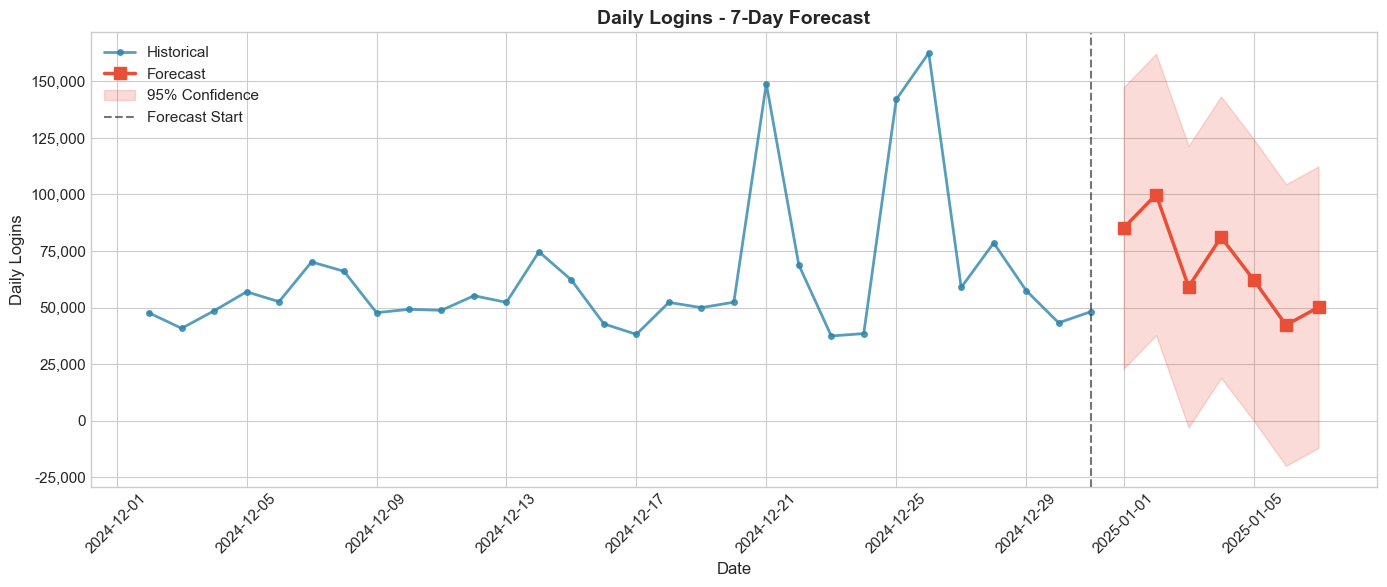

In [12]:
def plot_forecast_with_context(train_df, forecast_df, target, context_days=30):
    """Plot forecast with historical context and confidence band.
    
    Args:
        train_df: Training data DataFrame
        forecast_df: Forecast DataFrame with 'date' and 'prediction'
        target: Target column name
        context_days: Number of historical days to show
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Historical data (last N days)
    historical = train_df.tail(context_days)
    
    # Calculate confidence band (using historical volatility)
    historical_std = train_df[target].tail(context_days).std()
    predictions = forecast_df['prediction'].values
    upper_band = predictions + 1.96 * historical_std
    lower_band = predictions - 1.96 * historical_std
    
    # Plot historical data
    ax.plot(
        historical['date'], 
        historical[target],
        'o-', 
        color='#2E86AB',
        linewidth=2,
        markersize=4,
        label='Historical',
        alpha=0.8
    )
    
    # Plot forecast
    ax.plot(
        forecast_df['date'],
        predictions,
        's-',
        color='#E94F37',
        linewidth=2.5,
        markersize=8,
        label='Forecast',
        zorder=5
    )
    
    # Confidence band
    ax.fill_between(
        forecast_df['date'],
        lower_band,
        upper_band,
        color='#E94F37',
        alpha=0.2,
        label='95% Confidence'
    )
    
    # Vertical line at forecast start
    ax.axvline(
        x=historical['date'].iloc[-1],
        color='#393E41',
        linestyle='--',
        linewidth=1.5,
        alpha=0.7,
        label='Forecast Start'
    )
    
    # Formatting
    ax.set_xlabel('Date')
    ax.set_ylabel(target.replace('_', ' ').title())
    ax.set_title(f'{target.replace("_", " ").title()} - 7-Day Forecast', fontweight='bold')
    ax.legend(loc='upper left')
    
    # Format y-axis with thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig, ax

# Plot daily logins forecast
fig, ax = plot_forecast_with_context(
    train_df, 
    forecasts['daily_logins'], 
    'daily_logins',
    context_days=HISTORICAL_CONTEXT_DAYS
)
plt.show()

### 8.2 Daily Deposits Forecast

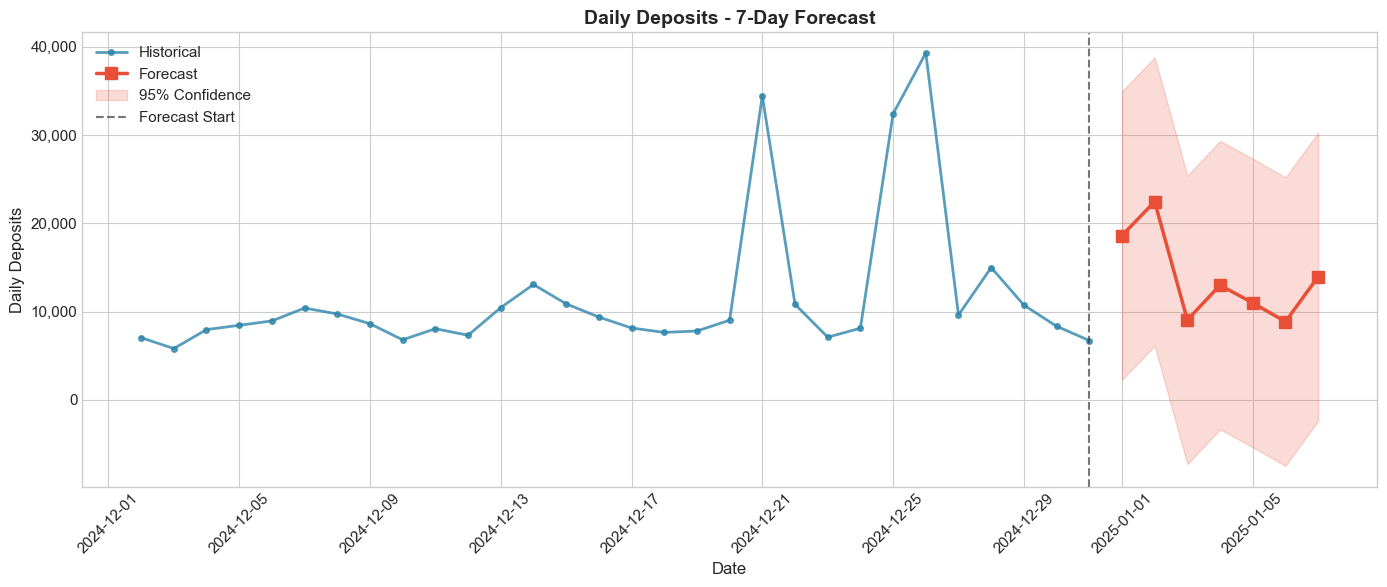

In [13]:
# Plot daily deposits forecast
fig, ax = plot_forecast_with_context(
    train_df, 
    forecasts['daily_deposits'], 
    'daily_deposits',
    context_days=HISTORICAL_CONTEXT_DAYS
)
plt.show()

### 8.3 Daily Deposit Volume (GBP) Forecast

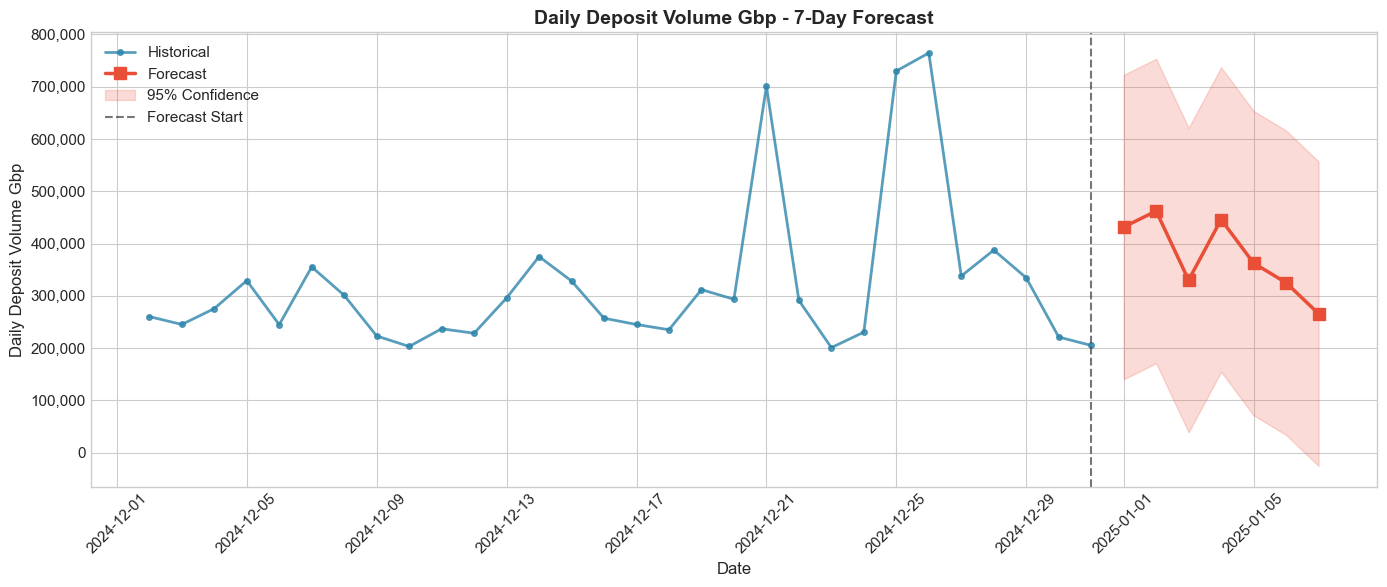

In [14]:
# Plot daily deposit volume forecast
fig, ax = plot_forecast_with_context(
    train_df, 
    forecasts['daily_deposit_volume_gbp'], 
    'daily_deposit_volume_gbp',
    context_days=HISTORICAL_CONTEXT_DAYS
)
plt.show()

### 8.4 Combined Forecast Dashboard

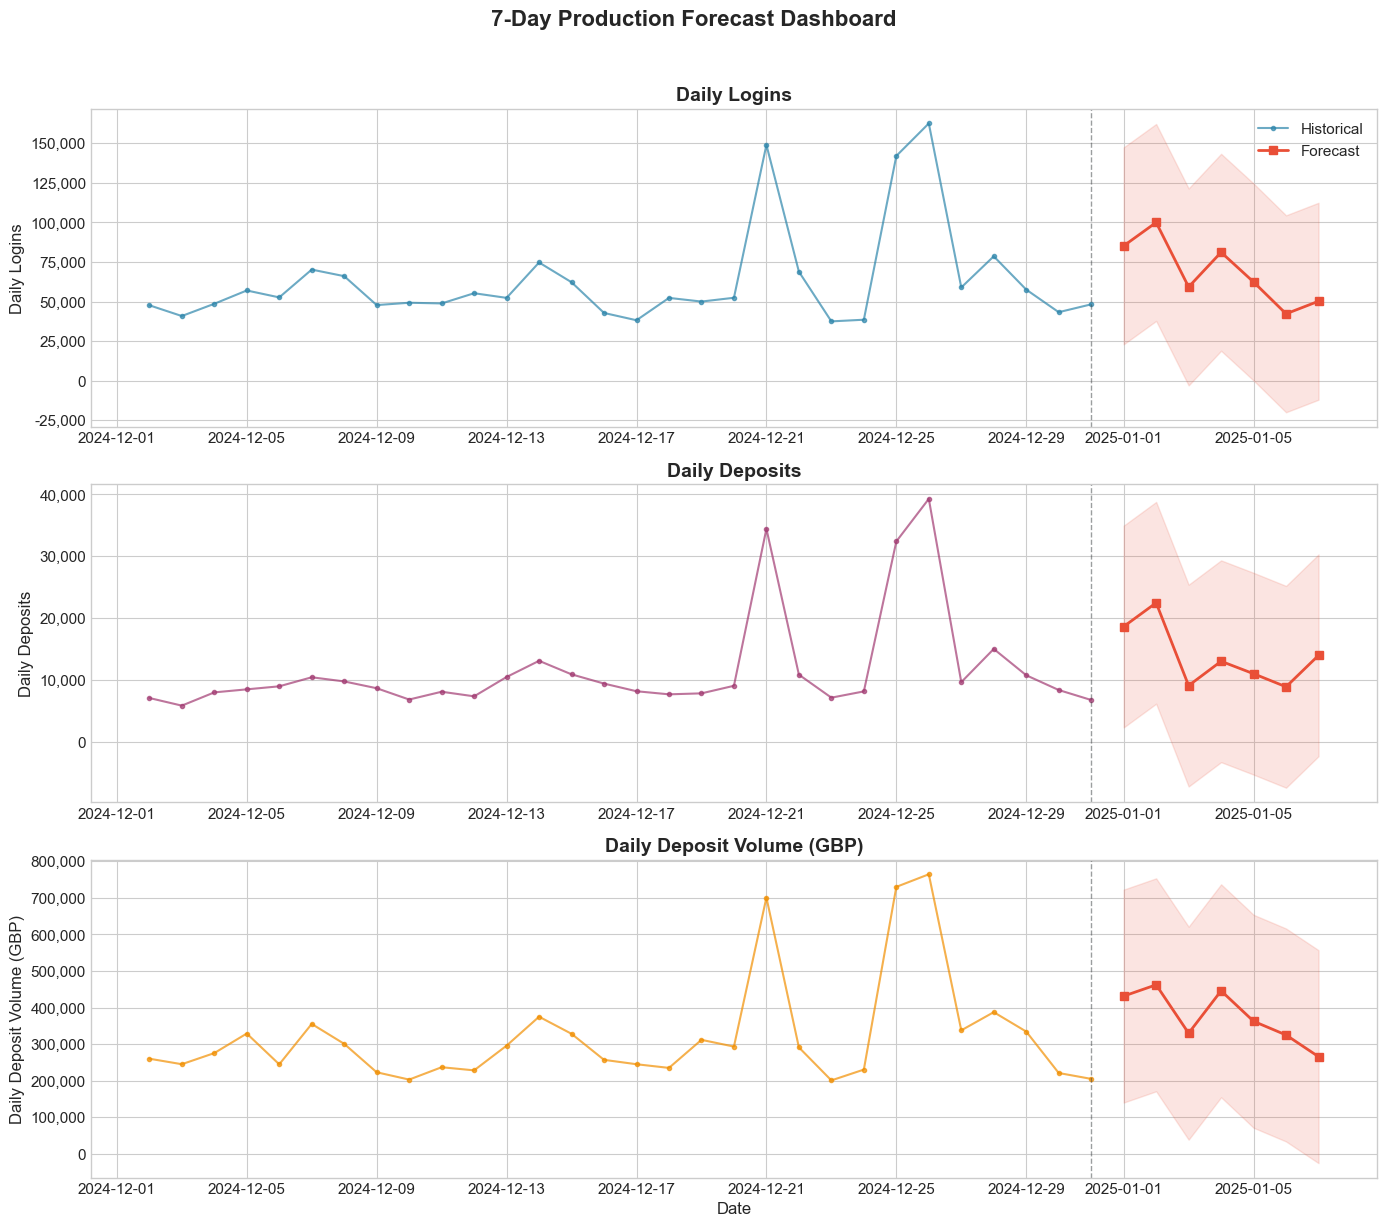

In [15]:
# Create a combined dashboard view
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

colors = ['#2E86AB', '#A23B72', '#F18F01']
titles = ['Daily Logins', 'Daily Deposits', 'Daily Deposit Volume (GBP)']

for i, (target, ax, color, title) in enumerate(zip(TARGETS, axes, colors, titles)):
    historical = train_df.tail(HISTORICAL_CONTEXT_DAYS)
    forecast_df = forecasts[target]
    predictions = forecast_df['prediction'].values
    
    # Historical std for confidence band
    historical_std = train_df[target].tail(HISTORICAL_CONTEXT_DAYS).std()
    upper_band = predictions + 1.96 * historical_std
    lower_band = predictions - 1.96 * historical_std
    
    # Plot historical
    ax.plot(
        historical['date'], 
        historical[target],
        'o-', 
        color=color,
        linewidth=1.5,
        markersize=3,
        label='Historical',
        alpha=0.7
    )
    
    # Plot forecast
    ax.plot(
        forecast_df['date'],
        predictions,
        's-',
        color='#E94F37',
        linewidth=2,
        markersize=6,
        label='Forecast'
    )
    
    # Confidence band
    ax.fill_between(
        forecast_df['date'],
        lower_band,
        upper_band,
        color='#E94F37',
        alpha=0.15
    )
    
    # Vertical line
    ax.axvline(
        x=historical['date'].iloc[-1],
        color='#393E41',
        linestyle='--',
        linewidth=1,
        alpha=0.5
    )
    
    ax.set_ylabel(title)
    ax.set_title(title, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Date')
plt.suptitle('7-Day Production Forecast Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Export Forecast

Save the forecast results to CSV for downstream consumption.

In [16]:
# Prepare export DataFrame
export_df = combined_forecast.copy()

# Add metadata columns
export_df['forecast_generated_at'] = pd.Timestamp.now()
export_df['model_type'] = 'ensemble'
export_df['model_components'] = 'seasonal_naive_0.4_xgboost_0.6'
export_df['forecast_horizon'] = FORECAST_HORIZON
export_df['training_end_date'] = train_df['date'].iloc[-1]

# Round predictions to integers (counts/volumes)
for target in TARGETS:
    export_df[target] = export_df[target].round(0).astype(int)

# Save to CSV
output_path.parent.mkdir(parents=True, exist_ok=True)
export_df.to_csv(output_path, index=False)

print("Forecast Export")
print("=" * 50)
print(f"Output Path: {output_path}")
print(f"Rows: {len(export_df)}")
print(f"Columns: {list(export_df.columns)}")
print("\nExport successful!")

Forecast Export
Output Path: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\forecast_output.csv
Rows: 7
Columns: ['date', 'day_of_week', 'daily_logins', 'daily_deposits', 'daily_deposit_volume_gbp', 'forecast_generated_at', 'model_type', 'model_components', 'forecast_horizon', 'training_end_date']

Export successful!


In [17]:
# Display exported data
print("\nExported Forecast Data:")
export_df


Exported Forecast Data:


,date,day_of_week,daily_logins,daily_deposits,daily_deposit_volume_gbp,forecast_generated_at,model_type,model_components,forecast_horizon,training_end_date
0,2025-01-01,Wednesday,85189,18618,431423,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31
1,2025-01-02,Thursday,99983,22462,462256,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31
2,2025-01-03,Friday,59225,9060,329947,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31
3,2025-01-04,Saturday,81130,13000,445895,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31
4,2025-01-05,Sunday,62344,10984,362527,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31
5,2025-01-06,Monday,42261,8865,325045,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31
6,2025-01-07,Tuesday,50200,13957,265771,2026-01-04 21:12:12.073744,ensemble,seasonal_naive_0.4_xgboost_0.6,7,2024-12-31


## 10. Comparison with Historical Averages

In [18]:
# Compare forecast with recent historical averages
comparison_periods = {
    'Last 7 Days': 7,
    'Last 14 Days': 14,
    'Last 30 Days': 30
}

comparison_data = []

for target in TARGETS:
    row = {'Metric': target.replace('_', ' ').title()}
    
    # Forecast average
    row['Forecast (7-day avg)'] = combined_forecast[target].mean()
    
    # Historical averages
    for period_name, days in comparison_periods.items():
        row[period_name + ' Avg'] = train_df[target].tail(days).mean()
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("Forecast vs Historical Comparison")
print("=" * 80)
comparison_df

Forecast vs Historical Comparison


,Metric,Forecast (7-day avg),Last 7 Days Avg,Last 14 Days Avg,Last 30 Days Avg
0,Daily Logins,"68,618.70","84,446.86","74,265.00","63,130.07"
1,Daily Deposits,"13,849.23","17,445.29","14,793.29","11,608.60"
2,Daily Deposit Volume Gbp,"374,694.70","425,769.43","374,570.36","321,585.37"


In [19]:
# Percentage change from recent history
print("\nPercentage Change from Last 7 Days:")
for target in TARGETS:
    forecast_avg = combined_forecast[target].mean()
    historical_avg = train_df[target].tail(7).mean()
    pct_change = ((forecast_avg - historical_avg) / historical_avg) * 100
    
    direction = "increase" if pct_change > 0 else "decrease"
    print(f"  {target}: {pct_change:+.1f}% ({direction})")


Percentage Change from Last 7 Days:
  daily_logins: -18.7% (decrease)
  daily_deposits: -20.6% (decrease)
  daily_deposit_volume_gbp: -12.0% (decrease)


## 11. Summary and Next Steps

### Summary

This notebook demonstrated a production-ready forecasting pipeline:

1. **Data Loading**: Loaded synthetic volume data with proper date handling
2. **Model Selection**: Built an ensemble combining Seasonal Naive (40%) and XGBoost (60%)
3. **Training**: Trained on the most recent 365 days of data
4. **Forecasting**: Generated 7-day ahead forecasts for all three target metrics
5. **Visualization**: Created presentation-ready charts with confidence intervals
6. **Export**: Saved forecast results to CSV for downstream consumption

### Key Results

In [20]:
# Final summary
print("=" * 60)
print("PRODUCTION FORECAST SUMMARY")
print("=" * 60)
print(f"\nForecast Period: {combined_forecast['date'].min().date()} to {combined_forecast['date'].max().date()}")
print(f"Training Data: {len(train_df):,} days")
print(f"Model: Ensemble (Seasonal Naive 40% + XGBoost 60%)")
print("\n7-Day Totals:")
for target in TARGETS:
    total = combined_forecast[target].sum()
    avg = combined_forecast[target].mean()
    print(f"  {target}: {total:,.0f} total ({avg:,.0f} daily avg)")
print(f"\nOutput: {output_path}")
print("=" * 60)

PRODUCTION FORECAST SUMMARY

Forecast Period: 2025-01-01 to 2025-01-07
Training Data: 365 days
Model: Ensemble (Seasonal Naive 40% + XGBoost 60%)

7-Day Totals:
  daily_logins: 480,331 total (68,619 daily avg)
  daily_deposits: 96,945 total (13,849 daily avg)
  daily_deposit_volume_gbp: 2,622,863 total (374,695 daily avg)

Output: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\forecast_output.csv


### Next Steps for Production Deployment

1. **Model Registry**: Register the ensemble model in a model registry (MLflow, Weights & Biases)

2. **Automation**: Set up scheduled forecast runs using:
   - Airflow DAG for daily/weekly forecast generation
   - CI/CD pipeline for model retraining on new data

3. **Monitoring**: Implement forecast monitoring:
   - Track prediction vs actual (backtest)
   - Alert on significant forecast errors
   - Monitor for data drift

4. **API Integration**: Expose forecasts via REST API:
   - FastAPI endpoint for real-time predictions
   - Batch prediction service for downstream consumers

5. **Dashboard**: Build stakeholder dashboard:
   - Streamlit/Dash app for interactive exploration
   - Automated reporting with scheduled emails

6. **Model Improvement**: Continuous improvement cycle:
   - A/B testing new model configurations
   - Feature engineering (external data integration)
   - Hyperparameter optimization

---

**End of Notebook 08 - Final Production Forecast**